In [ ]:
!(pip install unidecode)

In [ ]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn . preprocessing import OrdinalEncoder,Normalizer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold,mutual_info_classif

#Importar Dataset desde google drive

  Si no funciona también puede importar el dataset de manera manual

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!(cp drive/MyDrive/MailCustomer.csv sample_data/)

#Exploración de los datos

In [ ]:
data = pd.read_csv ( 'drive/MyDrive/MailCustomer.csv' , index_col = 'CustomerKey' , sep = ';' , encoding = 'ISO-8859-1' )
print(len(data.columns))

31


In [ ]:
print(data.head())
# print("-------------------")
print(data.tail())

             GeographyKey CustomerAlternateKey Title  FirstName MiddleName  \
CustomerKey                                                                  
11000                  26           AW00011000   NaN        Jon          V   
11001                  37           AW00011001   NaN     Eugene          L   
11002                  31           AW00011002   NaN      Ruben        NaN   
11003                  11           AW00011003   NaN    Christy        NaN   
11004                  19           AW00011004   NaN  Elizabeth        NaN   

            LastName  NameStyle  BirthDate MaritalStatus Suffix Gender  \
CustomerKey                                                              
11000           Yang          0     4/8/66             M    NaN      M   
11001          Huang          0  5/14/1965             S    NaN      M   
11002         Torres          0    8/12/65             M    NaN      M   
11003            Zhu          0  2/15/1968             S    NaN      F   
11004    

Comprobando cuantos campos faltan en cada variable

(0.0, 18484.0)

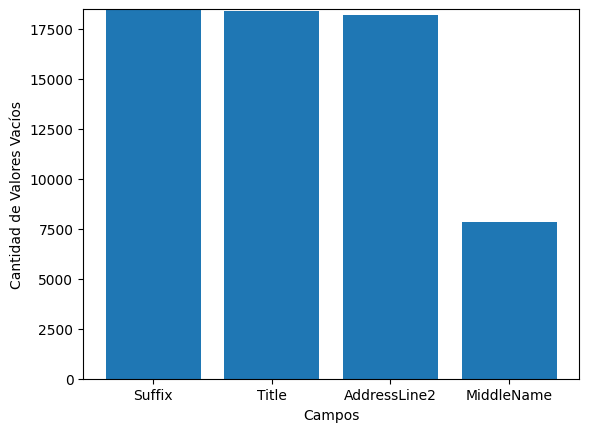

In [ ]:
null_counts = data.isnull().sum().sort_values(ascending=False)
filtered_columns = null_counts[null_counts > 0].index
fig, ax = plt.subplots()
ax.bar(x=filtered_columns, height=null_counts[filtered_columns])
ax.set_xlabel('Campos')
ax.set_ylabel('Cantidad de Valores Vacíos')
ax.set_ylim(top=18484)

En los campos, suffix,title y AddressLine2 faltan muchos valores, por lo que nos lo cargamos

Ordenamos las edades para ver el rango de valores

In [ ]:
print ( data['Age'].sort_values ( ascending = False ) )

CustomerKey
12725    105
16455    104
14841    103
18034    103
14992    103
16325    102
16471    102
25527    102
28743    100
24713     99
15628     98
17640     98
25325     97
26314     97
21684     97
24035     96
25416     96
16563     96
19430     95
15074     95
15075     94
23190     94
22453     93
20866     93
16568     93
15519     93
17619     92
22629     92
14166     92
20865     92
23208     91
14768     91
13919     91
11845     91
21057     90
24836     90
26355     90
13776     89
28537     89
12810     89
19449     89
26358     89
25978     89
11555     89
26742     88
19456     88
20893     88
24350     88
26628     88
24070     88
11554     88
19457     88
22931     87
21154     87
19404     87
12823     87
14648     87
18058     87
16264     87
29370     87
26364     87
17658     86
19465     86
18690     86
26843     86
21201     86
20737     86
24081     86
12978     86
17276     85
29177     85
19464     85
12758     85
26844     85
16212     85
22331     85


Comprobamos si hay tuplas duplicadas

In [ ]:
li=len(data)
data.drop_duplicates()
lf=len(data)
print(li-lf)

0


Hay caracteres raros

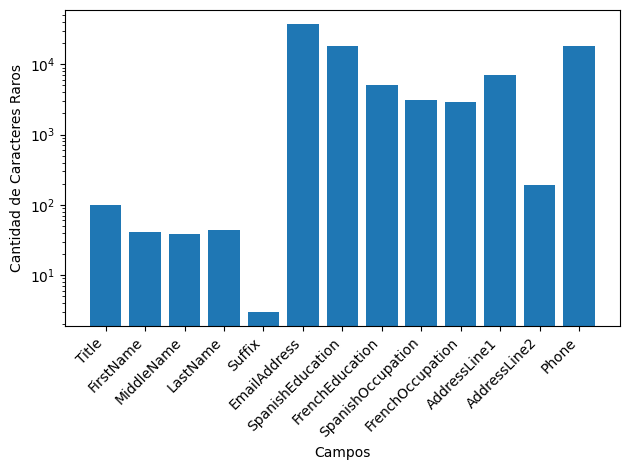

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

def count_special_characters(text):
    if isinstance(text, str):
        special_chars = re.findall(r"[^\w\s\d\-+/\\]", text)
        return len(special_chars)
    else:
        return 0

special_chars_count = data.applymap(count_special_characters)

columns_with_special_chars = special_chars_count.columns[special_chars_count.sum() > 0]

total_special_chars_count = special_chars_count[columns_with_special_chars].sum()

fig, ax = plt.subplots()
ax.bar(x=total_special_chars_count.index, height=total_special_chars_count)

ax.set_xlabel('Campos')
ax.set_ylabel('Cantidad de Caracteres Raros')

ax.set_yscale('log')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Hay fechas en formatos distinos

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

from datetime import datetime
def mostrar_cantidad_fechas(data,columna):
  print('Mostrando formatos de las fechas de la columna '+columna)
  def is_valid_date(date_string, date_format):
    try:
        datetime.strptime(date_string, date_format)
        return True
    except ValueError:
        return False
  def count_dates_format(date):
    if(is_valid_date(date,'%m/%d/%Y')):
      return True
    else:
      return False
  date_Y_count = data[columna].apply(count_dates_format)

  total_date_Y_count = date_Y_count.value_counts()

  fig, ax = plt.subplots()
  total_date_Y_count.plot(kind='bar', ax=ax)
  ax.set_xlabel('Formato')
  ax.set_ylabel('Cantidad de instancias')
  ax.set_xticklabels(['m/d/YYYY','m/d/yy'], rotation=45, ha='right')

  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()


Mostrando formatos de las fechas de la columna BirthDate


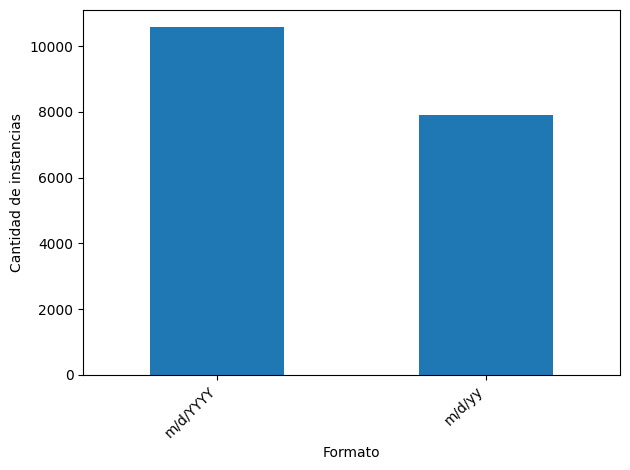

Mostrando formatos de las fechas de la columna DateFirstPurchase


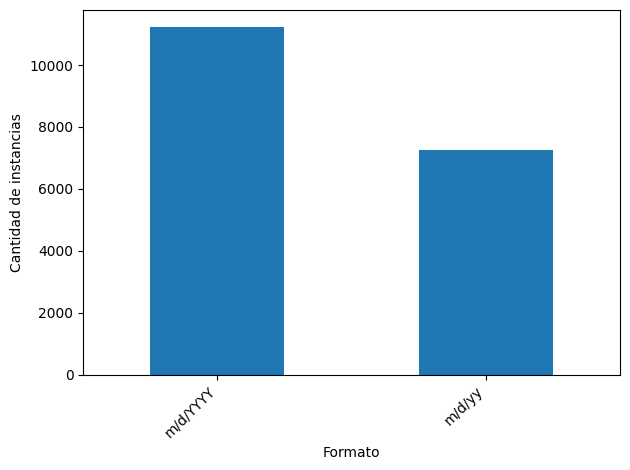

In [ ]:
mostrar_cantidad_fechas(data,'BirthDate')
mostrar_cantidad_fechas(data,'DateFirstPurchase')

Errores encontrados:


1.   Hay campos sin valor,(Title,MiddleName,Suffix,AddressLine2)
2.   Las fechas están en formatos distintos
3.   En algunos campos hay  caracteres raros
4.   La edad no se corresponde con la fecha



#Limpieza de Datos

In [ ]:
processedData = pd.read_csv ( 'drive/MyDrive/MailCustomer.csv' , index_col = 'CustomerKey' , sep = ';' , encoding = 'ISO-8859-1' )

In [ ]:
from datetime import datetime
def is_valid_date(date_string, date_format):
    try:
        datetime.strptime(date_string, date_format)
        return True
    except ValueError:
        return False
def change_wrong_dates(date):
  global min_year
  if(is_valid_date(date,'%m/%d/%Y')):

    return date
  else:

    timeData = datetime.strptime(date, '%m/%d/%y')
    new_year = timeData.year
    if timeData.year>=2014:

      new_year = timeData.year - 100
    new_date = datetime(new_year, timeData.month, timeData.day).strftime('%-m/%-d/%Y')
    return new_date



processedData['BirthDate'] = processedData['BirthDate'].apply(change_wrong_dates)
processedData['DateFirstPurchase'] = processedData['DateFirstPurchase'].apply(change_wrong_dates)


In [ ]:
from datetime import datetime

def calculate_age(birthdate):
    today = datetime.today()
    birthdate = datetime.strptime(birthdate, "%m/%d/%Y")
    age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return age

processedData['Age'] = processedData['BirthDate'].apply(calculate_age)

In [ ]:
import re

def remove_special_character(text):
    if isinstance(text, str):
      aux_text = re.sub(r"\x82", "", text)
      return re.sub(r"[^\w\s\d\-+/\\]", "", aux_text)
    else:
        return text

processedData = processedData.applymap(remove_special_character)

Eliminamos las columnas en las que faltaban muchos datos, dado que no se podrán rellenar

In [ ]:
null_counts = processedData.isnull().sum().sort_values(ascending=False)

campos_vacios = null_counts[null_counts > 15000].index.tolist()
processedData = processedData.drop(['Suffix','Title', 'AddressLine2'] , axis = 'columns')
print('Se han eliminado los siguientes campos: '+str(campos_vacios))

Se han eliminado los siguientes campos: ['Suffix', 'Title', 'AddressLine2']


In [ ]:
processedData['MiddleName']=OrdinalEncoder().fit_transform ( processedData[['MiddleName']])

In [ ]:
imputer = SimpleImputer ( fill_value = np.nan , strategy = 'mean')
aux = processedData[['MiddleName']]
processedData['MiddleName'] = imputer.fit_transform(aux)


##Transformación de datos

In [ ]:
def unfold_date(date):
    d = datetime.strptime(date, '%m/%d/%Y')
    return pd.Series([d.day, d.month, d.year], index=['BirthDateDay', 'BirthDateMonth', 'BirthDateYear'])

aux = pd.DataFrame(columns=['BirthDateDay','BirthDateMonth','BirthDateYear'])
aux[['BirthDateDay', 'BirthDateMonth', 'BirthDateYear']] = processedData['BirthDate'].apply(unfold_date)
aux[['BirthDateDay', 'BirthDateMonth', 'BirthDateYear']] = aux[['BirthDateDay', 'BirthDateMonth', 'BirthDateYear']].astype('int32')
processedData =pd.concat([processedData,aux],axis='columns')
processedData = processedData.drop(['BirthDate'] , axis = 'columns')

In [ ]:
def unfold_date2(date):
    d = datetime.strptime(date, '%m/%d/%Y')
    return pd.Series([d.day, d.month, d.year], index=['FirstPurchaseDateDay', 'FirstPurchaseDateMonth', 'FirstPurchaseDateYear'])

aux = pd.DataFrame(columns=['FirstPurchaseDateDay','FirstPurchaseDateMonth','FirstPurchaseDateYear'])
aux[['FirstPurchaseDateDay', 'FirstPurchaseDateMonth', 'FirstPurchaseDateYear']] = processedData['DateFirstPurchase'].apply(unfold_date2)
aux[['FirstPurchaseDateDay', 'FirstPurchaseDateMonth', 'FirstPurchaseDateYear']] = aux[['FirstPurchaseDateDay', 'FirstPurchaseDateMonth', 'FirstPurchaseDateYear']].astype('int32')
processedData = pd.concat([processedData,aux],axis='columns')
processedData = processedData.drop(['DateFirstPurchase'] , axis = 'columns')

In [ ]:
for i in processedData . columns :
  if len(processedData[ i ].unique().tolist() )< 50:
    print(f'Estableciendo como categoría la columna {i}')
    processedData[ i ] = processedData [i]. astype ( 'category')
    #processedData[i]=OrdinalEncoder().fit_transform ( processedData[[i]])


Estableciendo como categoría la columna MiddleName
Estableciendo como categoría la columna NameStyle
Estableciendo como categoría la columna MaritalStatus
Estableciendo como categoría la columna Gender
Estableciendo como categoría la columna YearlyIncome
Estableciendo como categoría la columna TotalChildren
Estableciendo como categoría la columna NumberChildrenAtHome
Estableciendo como categoría la columna EnglishEducation
Estableciendo como categoría la columna SpanishEducation
Estableciendo como categoría la columna FrenchEducation
Estableciendo como categoría la columna EnglishOccupation
Estableciendo como categoría la columna SpanishOccupation
Estableciendo como categoría la columna FrenchOccupation
Estableciendo como categoría la columna HouseOwnerFlag
Estableciendo como categoría la columna NumberCarsOwned
Estableciendo como categoría la columna CommuteDistance
Estableciendo como categoría la columna Region
Estableciendo como categoría la columna BikeBuyer
Estableciendo como cate

Borramos los registros duplicados

In [ ]:
li=len(processedData)
processedData.drop_duplicates()
lf=len(processedData)
print(li-lf)

0


#Reducción de dimensionalidad

Vemos el tamaño inicial cuando inicia la fase

In [ ]:
print(len(processedData.columns))

32


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18484 entries, 11000 to 29483
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   GeographyKey            18484 non-null  int64   
 1   CustomerAlternateKey    18484 non-null  object  
 2   FirstName               18484 non-null  object  
 3   MiddleName              18484 non-null  category
 4   LastName                18484 non-null  object  
 5   NameStyle               18484 non-null  category
 6   MaritalStatus           18484 non-null  category
 7   Gender                  18484 non-null  category
 8   EmailAddress            18484 non-null  object  
 9   YearlyIncome            18484 non-null  category
 10  TotalChildren           18484 non-null  category
 11  NumberChildrenAtHome    18484 non-null  category
 12  EnglishEducation        18484 non-null  category
 13  SpanishEducation        18484 non-null  category
 14  FrenchEducation   

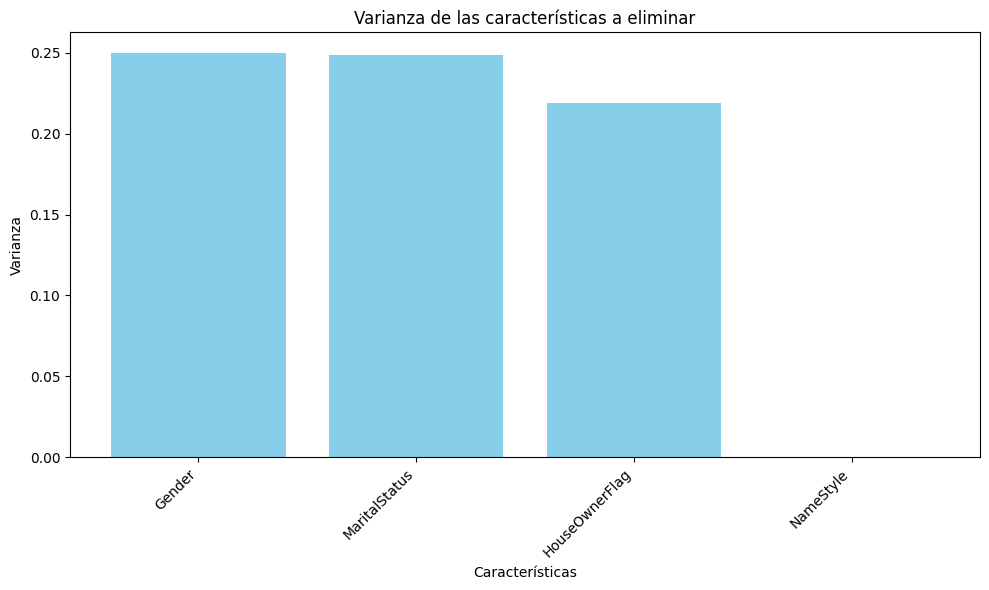

In [ ]:
selector = VarianceThreshold ( threshold =0.25) # Umbral de varianza para seleccionar caracteristicas
print (  processedData. info () )
newData = OrdinalEncoder () . fit_transform ( processedData[processedData.columns])
sel = selector.fit( newData )
resultados = sel.get_support()
eliminar = []
variances = sel.variances_
variance_df = pd.DataFrame({'Feature': processedData.columns, 'Variance': variances})

for i in range(len(resultados)):
  if not resultados[i] and processedData.columns[i]!='BikeBuyer':
    eliminar.append(processedData.columns[i])
processedData = processedData.drop(eliminar, axis = 'columns')

for i in eliminar:
  print(f'Se ha eliminado la columna {i}')






variance_df = variance_df.sort_values(by='Variance', ascending=False)
variance_df_eliminar = variance_df[variance_df['Feature'].isin(eliminar)]

plt.figure(figsize=(10, 6))
plt.bar(variance_df_eliminar['Feature'], variance_df_eliminar['Variance'], color='skyblue')
plt.xlabel('Características')
plt.ylabel('Varianza')
plt.title('Varianza de las características a eliminar')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


  Viendo que variables tiene poca correlación con la variable a predecir

0     0.144913
1    -0.062301
2    -0.047756
5    -0.048164
7     0.072087
8     0.030365
9     0.124509
14    0.176337
15    0.072545
16    0.078754
17   -0.029851
18    0.103254
20    0.192036
27   -0.143347
Name: 21, dtype: float64


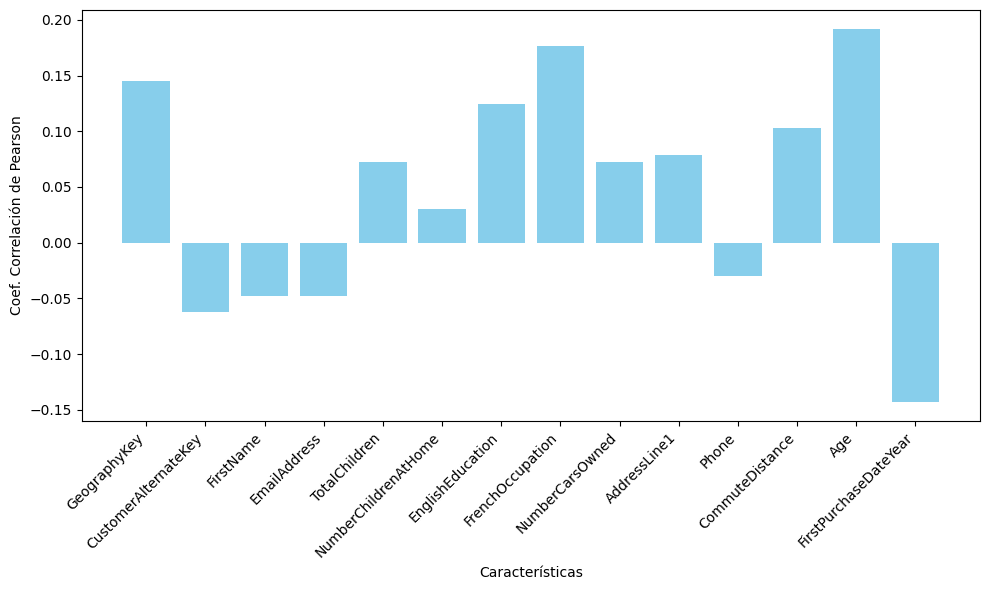

LaTEX:
\textit{GeographyKey}, \textit{CustomerAlternateKey}, \textit{FirstName}, \textit{EmailAddress}, \textit{TotalChildren}, \textit{NumberChildrenAtHome}, \textit{EnglishEducation}, \textit{FrenchOccupation}, \textit{NumberCarsOwned}, \textit{AddressLine1}, \textit{Phone}, \textit{CommuteDistance}, \textit{Age}, \textit{FirstPurchaseDateYear}, 


In [ ]:
index_of_bikebuyer = processedData.columns.get_loc('BikeBuyer')
newData = OrdinalEncoder () .fit_transform ( processedData[processedData.columns])
normalizedData = Normalizer () . fit_transform ( newData )
correlaciones =  pd.DataFrame( normalizedData ).corr( method ='pearson')[:][index_of_bikebuyer]
rango = 0.2
print(correlaciones[(correlaciones <=rango) & (correlaciones >=rango*-1)])


features_to_remove = correlaciones[(correlaciones <= rango) & (correlaciones >= rango * -1)].index
features_to_remove = processedData.columns[features_to_remove]
processedData = processedData.drop(columns=features_to_remove)

plt.figure(figsize=(10, 6))
plt.bar(features_to_remove, correlaciones[(correlaciones <= rango) & (correlaciones >= rango * -1)], color='skyblue')
plt.xlabel('Características')
plt.ylabel('Coef. Correlación de Pearson')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print('LaTEX:')
s=''
for i in features_to_remove:
   s+= '\\textit{'+str(i)+'}, '

print(s)

 Viendo que variables tienen  alta correlación entre sí

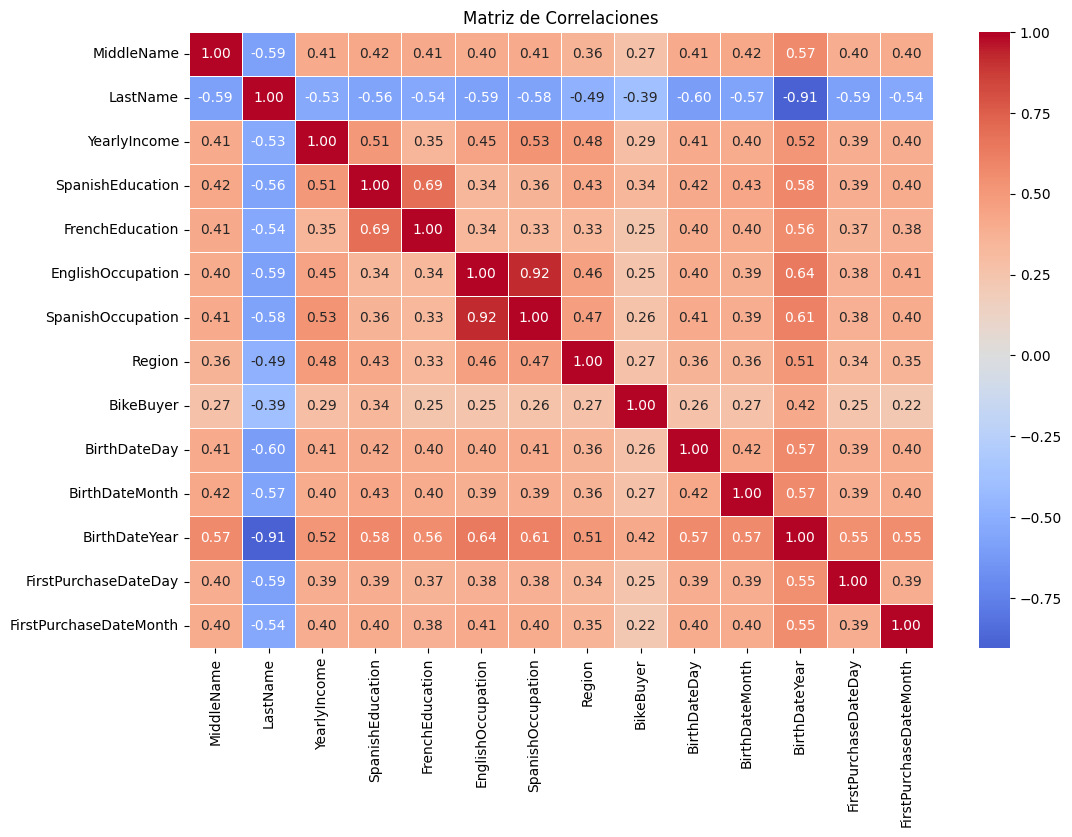

In [ ]:
def mostrar_correlaciones(processedData):
  index_of_bikebuyer = processedData.columns.get_loc('BikeBuyer')


  newData = OrdinalEncoder () .fit_transform ( processedData[processedData.columns])
  normalizedData = Normalizer () . fit_transform ( newData )
  correlaciones =  pd.DataFrame( normalizedData ).corr( method ='pearson')

  pd.set_option('display.max_rows', None)
  pd.set_option('display.max_columns', None)
  plt.figure(figsize=(12, 8))
  sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt=".2f",center=0, linewidths=.5,xticklabels=processedData.columns,yticklabels=processedData.columns)
  plt.title('Matriz de Correlaciones')
  plt.show()
mostrar_correlaciones(processedData)

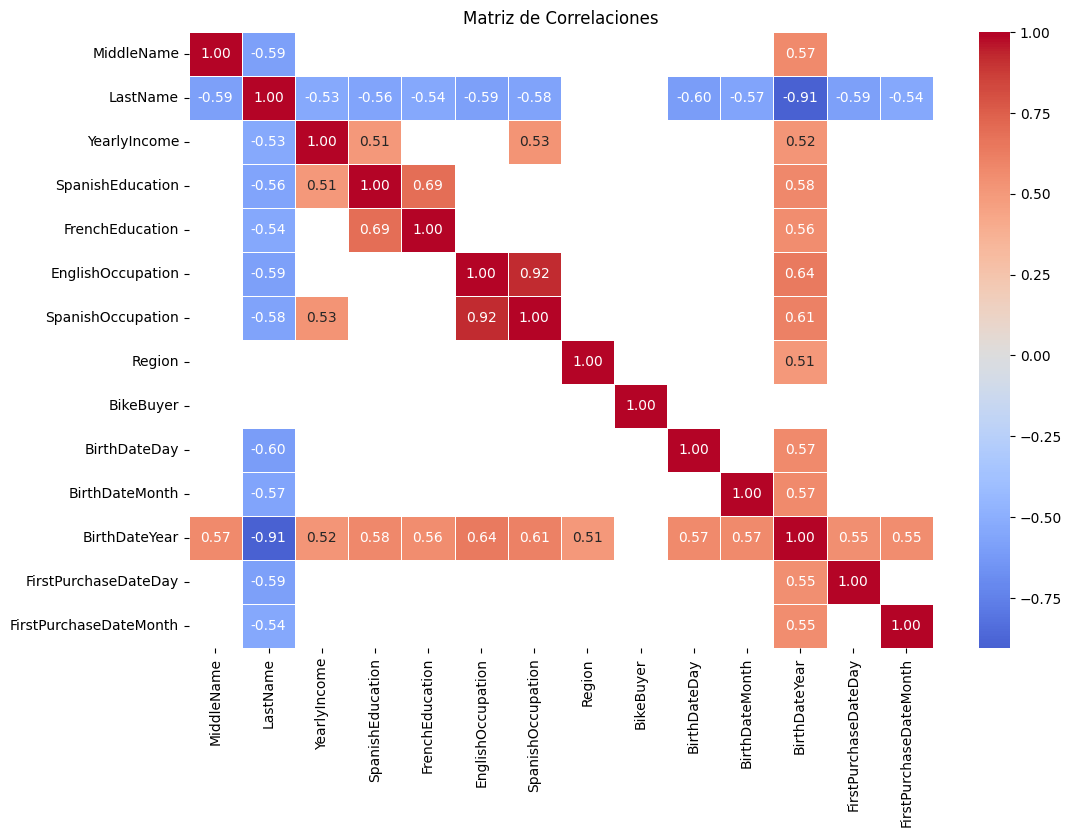

In [ ]:
def mostrar_correlaciones_umbral(processedData,rango):
  index_of_bikebuyer = processedData.columns.get_loc('BikeBuyer')


  newData = OrdinalEncoder () .fit_transform ( processedData[processedData.columns])
  normalizedData = Normalizer () . fit_transform ( newData )
  correlaciones =  pd.DataFrame( normalizedData ).corr( method ='pearson')

  nan_counts = correlaciones[(correlaciones >=rango)].isna().sum(axis=1)
  correlaciones = correlaciones[((correlaciones >=rango) | (correlaciones<=rango*-1))& (nan_counts < len(correlaciones))]
  plt.figure(figsize=(12, 8))
  sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt=".2f",center=0, linewidths=.5,xticklabels=processedData.columns,yticklabels=processedData.columns)
  plt.title('Matriz de Correlaciones')

  plt.show()
rango = 0.5
mostrar_correlaciones_umbral(processedData,rango)

In [ ]:
processedData = processedData.drop(columns='EnglishOccupation')

In [ ]:
def eliminar_muy_correlacionados(processedData):
  newData = OrdinalEncoder () .fit_transform ( processedData[processedData.columns])
  normalizedData = Normalizer () . fit_transform ( newData )
  correlaciones =  pd.DataFrame( normalizedData ).corr( method ='pearson')
  nan_counts = correlaciones[(correlaciones >=rango)].isna().sum(axis=1)
  correlaciones = correlaciones[((correlaciones >=rango) | (correlaciones<=rango*-1))& (nan_counts < len(correlaciones))]
  muy_correlacionados = (correlaciones.count()-1 > len(processedData.columns)/2)*processedData.columns
  muy_correlacionados = np.array(muy_correlacionados[muy_correlacionados!=''])
  print(muy_correlacionados)
  aux = processedData
  for i in muy_correlacionados:
    print('Se ha eliminado la columna '+i)
    aux = aux.drop(columns = i)

  return aux
processedData = eliminar_muy_correlacionados(processedData)

['LastName' 'BirthDateYear']
Se ha eliminado la columna LastName
Se ha eliminado la columna BirthDateYear


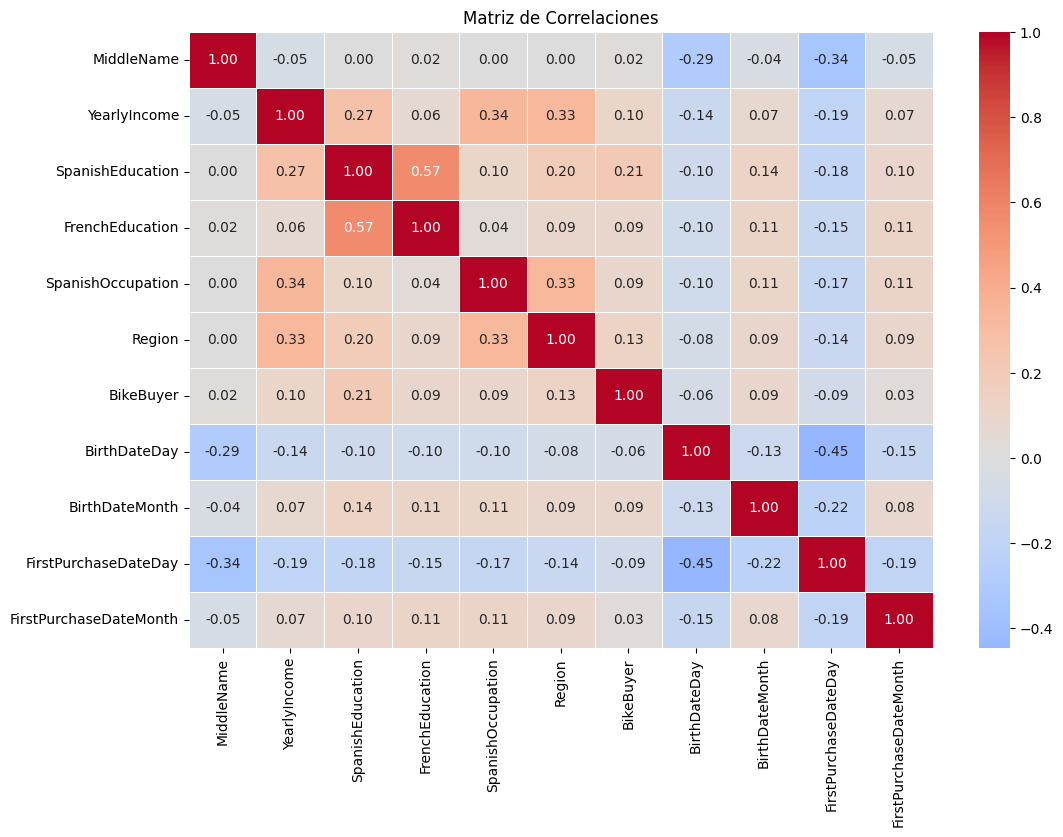

In [ ]:
mostrar_correlaciones(processedData)

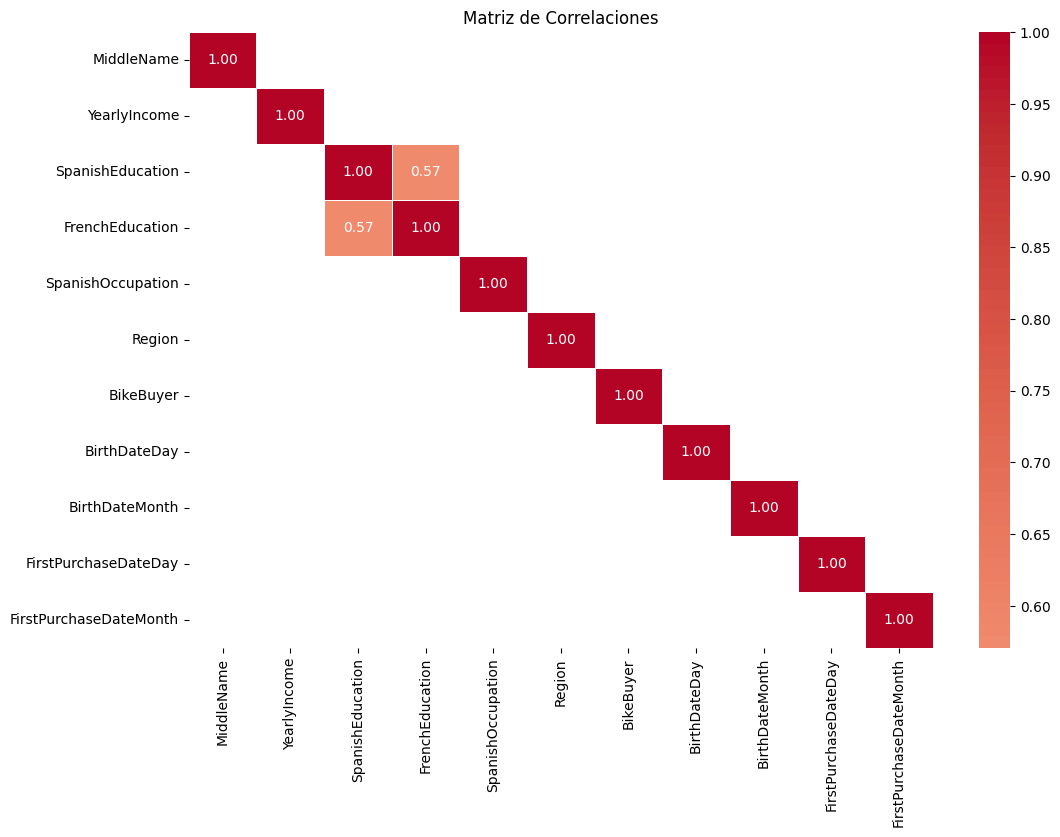

In [ ]:
mostrar_correlaciones_umbral(processedData,rango)